In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from os import makedirs
from os.path import join, exists, expanduser
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
!ls ~/.keras/models  
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/



    




Using TensorFlow backend.


In [2]:

all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input','data',  'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers:', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)


Scans found: 112120 , Total Headers: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
56599,00014082_007.png,No Finding,7,14082,29,F,AP,2500,2048,0.168,0.168,NaN,../input/data/images_007/images/00014082_007.png
73098,00018006_015.png,Effusion|Infiltration,15,18006,60,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_008/images/00018006_015.png
8970,00002356_008.png,No Finding,8,2356,64,F,PA,2714,2693,0.143,0.143,NaN,../input/data/images_002/images/00002356_008.png


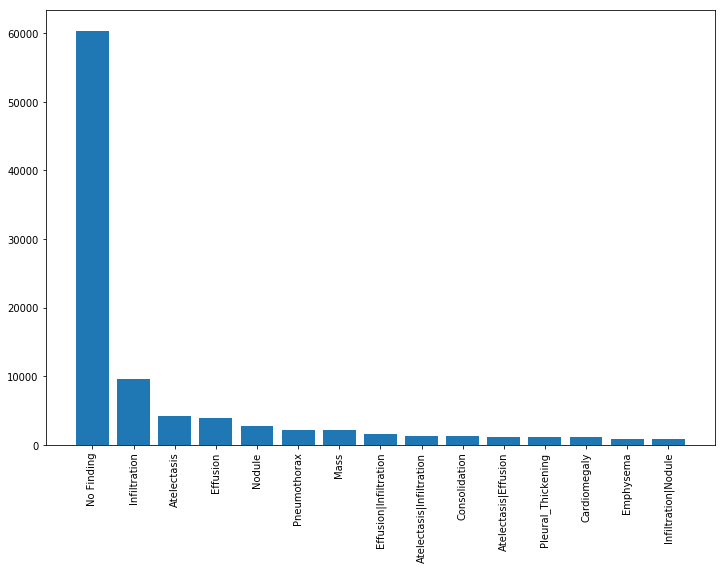

In [3]:
#Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels.
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
#Removing No Finding images
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
108407,00029385_006.png,,6,29385,52,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_012/images/00029385_006.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67693,00016729_002.png,Consolidation,2,16729,61,F,AP,2500,2048,0.168,0.168,NaN,../input/data/images_008/images/00016729_002.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72181,00017762_001.png,,1,17762,13,F,PA,2990,2991,0.143,0.143,NaN,../input/data/images_008/images/00017762_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print('All Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])


All Labels (14) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


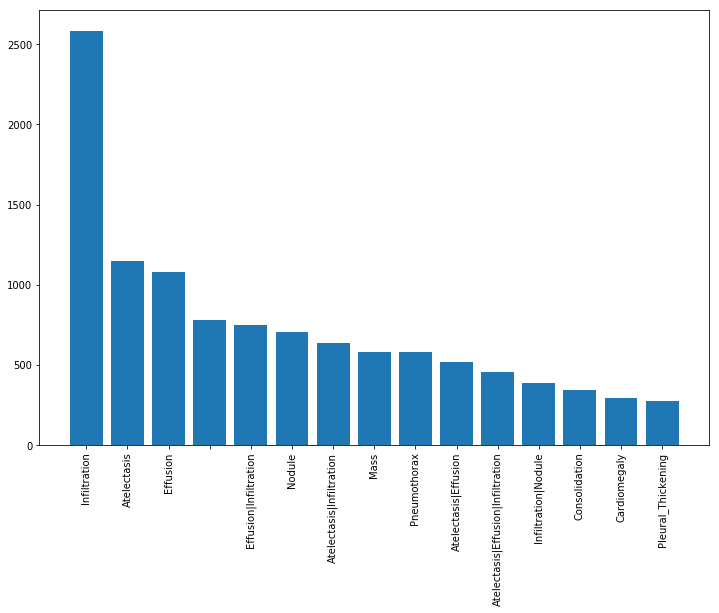

In [6]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(20000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [7]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [8]:
#Preparing training and test data
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [9]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])
print(all_labels)

train 15000 validation 5000
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [10]:
#Create Data Generators
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128,128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [11]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [12]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 15000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 5000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 5000 images


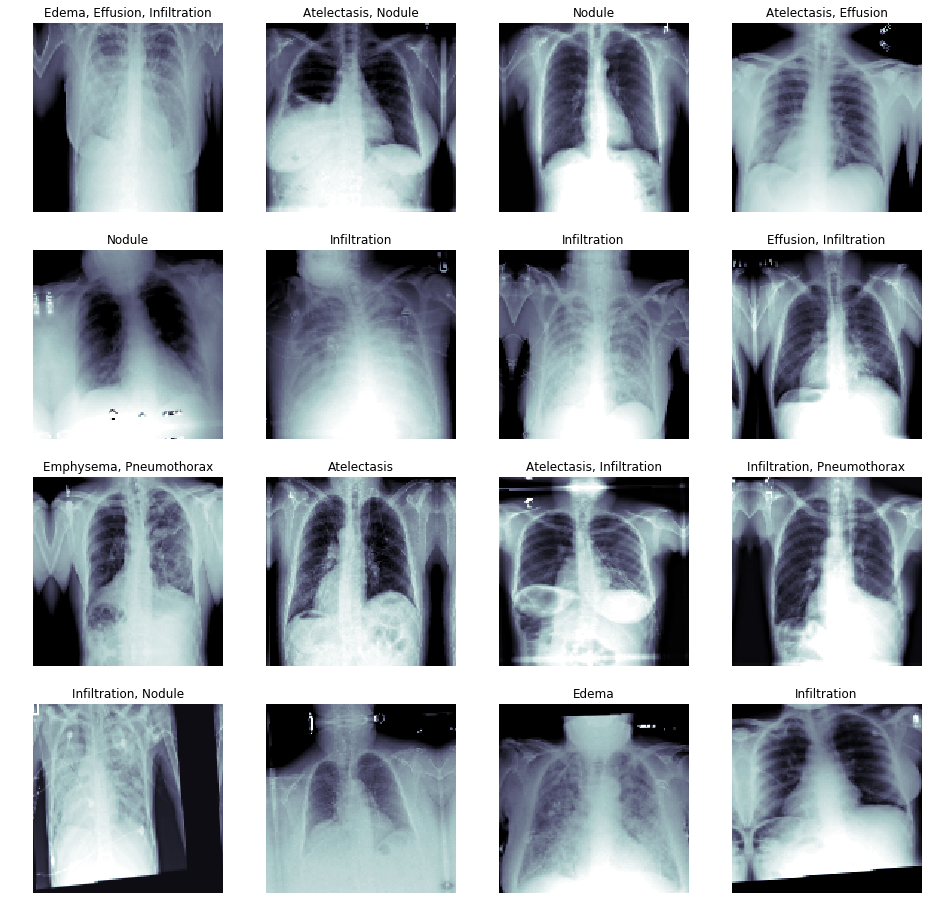

In [13]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [14]:
#Create a simple Model
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

class_weights = {0: 1.0787931408725853,
 1: 5.166320166320166,
 2: 3.7298311444652907,
 3: 6.675621222296844,
 4: 1.4675919090506422,
 5: 7.161383285302594,
 6: 10.22633744855967,
 7: 79.52,
 8: 1.0,
 9: 3.4694589877835953,
 10: 3.202319587628866,
 11: 9.1109074243813,
 12: 38.23076923076923,
 13: 5.6477272727272725}


res = ResNet50(input_shape=t_x.shape[1:], weights='imagenet', include_top=False)
# don't train existing weights
for layer in res.layers:
  layer.trainable = False







/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(all_labels), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [16]:
#compile the model
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [17]:
#Train the model
r = model.fit_generator(
  train_gen,
  validation_data=(test_X, test_Y),
  epochs=2,
  steps_per_epoch= 15000/160,
  callbacks = callbacks_list,
  validation_steps= 5000 / 1280,
  class_weight = class_weights
)


Epoch 1/2
94/93 [==============================] - 469s 5s/step - loss: 4.3372 - acc: 0.8401 - val_loss: 0.8051 - val_acc: 0.8555

Epoch 00001: val_loss improved from inf to 0.80514, saving model to xray_class_weights.best.hdf5
Epoch 2/2
94/93 [==============================] - 452s 5s/step - loss: 4.7535 - acc: 0.8360 - val_loss: 0.7681 - val_acc: 0.8425

Epoch 00002: val_loss improved from 0.80514 to 0.76808, saving model to xray_class_weights.best.hdf5


In [18]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 24.80%
Cardiomegaly: 6.35%
Consolidation: 11.82%
Edema: 5.37%
Effusion: 29.10%
Emphysema: 5.47%
Fibrosis: 3.91%
Hernia: 0.59%
Infiltration: 40.72%
Mass: 12.60%
Nodule: 12.79%
Pleural_Thickening: 8.01%
Pneumonia: 3.32%
Pneumothorax: 12.21%


In [19]:
pred_Y = model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 121s 118ms/step


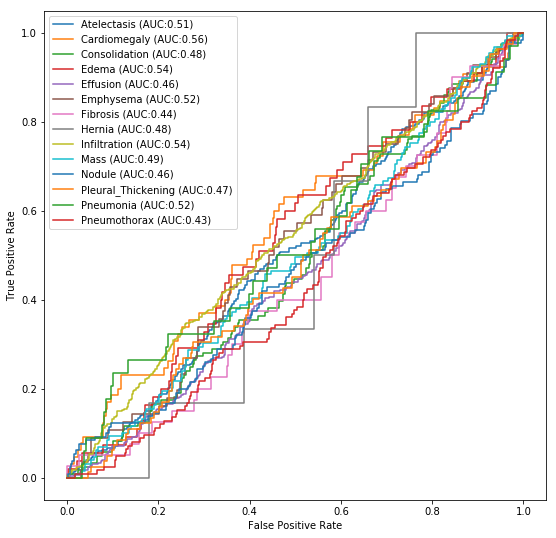

In [20]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')



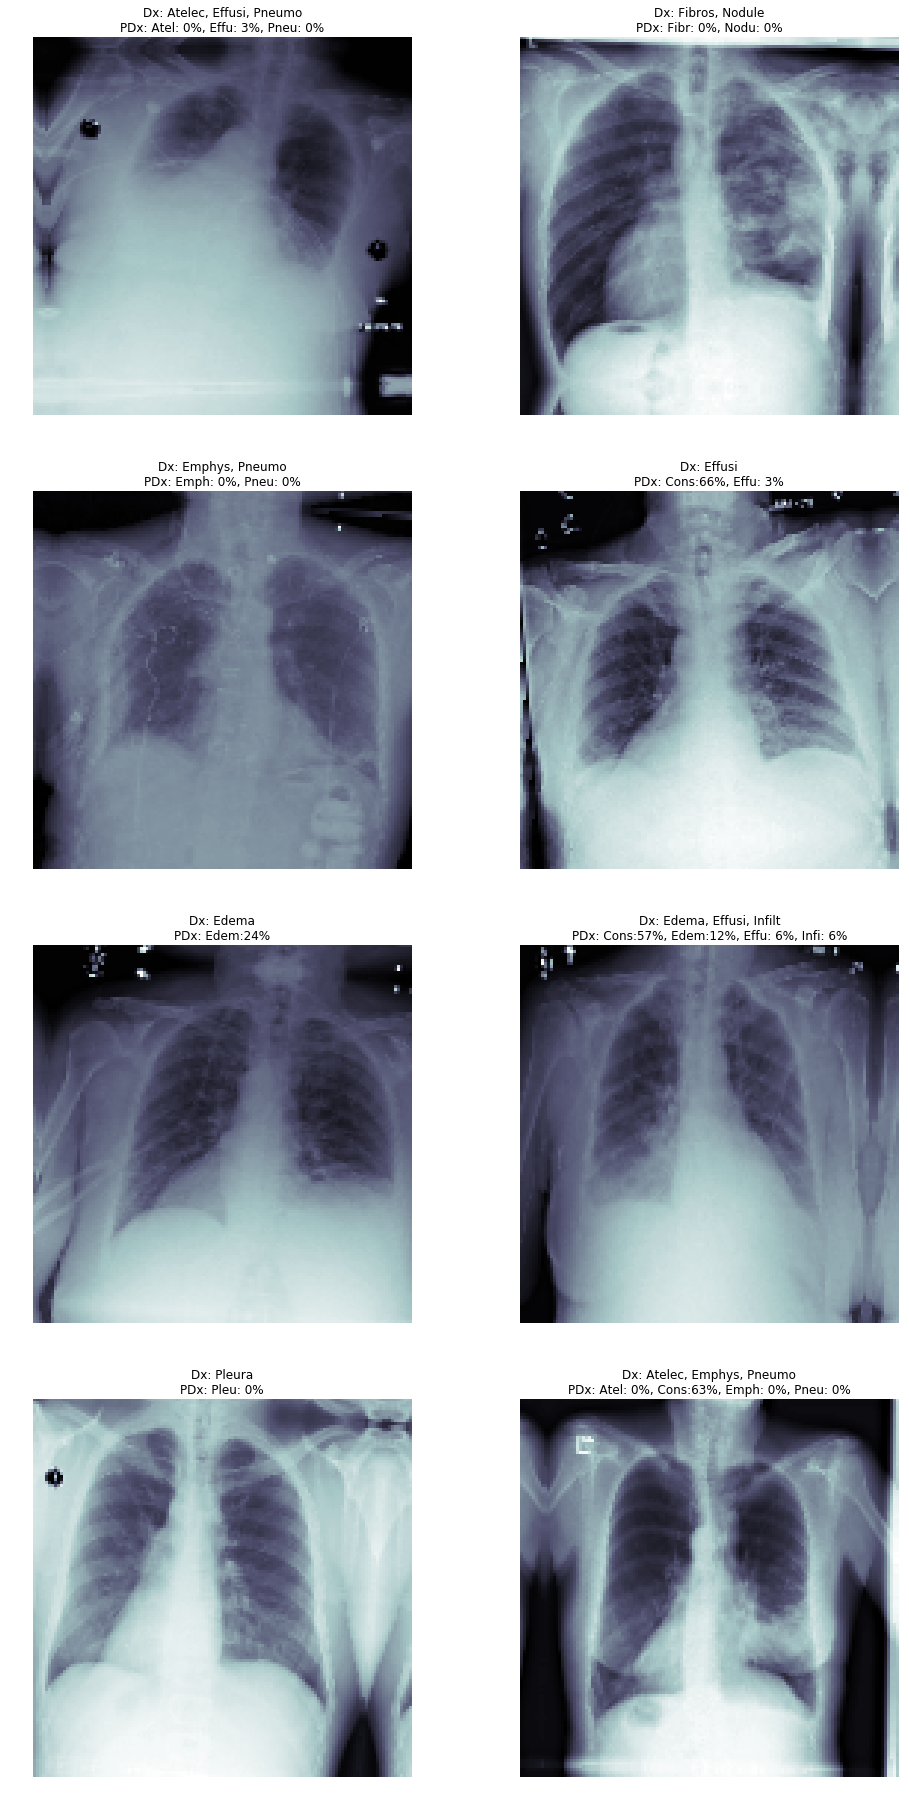

In [21]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [ ]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
vgg_IMAGE_SIZE = [224, 224]

#train_path = 'Datasets/train'
#valid_path = 'Datasets/test'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape=vgg_IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# our layers - you can add more if you want
x1 = Flatten()(vgg.output)

In [ ]:

prediction = Dense(len(all_labels), activation='softmax')(x1)

# create a model object
vggmodel = Model(inputs=vgg.input, outputs=prediction)
vggmodel.summary()

In [ ]:
#compile the model
vggmodel.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
vgg_train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = vgg_IMAGE_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

vgg_valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = vgg_IMAGE_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
vgg_test_X, vgg_test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = vgg_IMAGE_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

In [ ]:
vgg_t_x, vgg_t_y = next(vgg_train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(vgg_t_x, vgg_t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
#Train the model
vgg_r = vggmodel.fit_generator(
  vgg_train_gen,
  validation_data=(vgg_test_X, vgg_test_Y),
  epochs=2,
  steps_per_epoch= 15000/160,
  callbacks = callbacks_list,
  validation_steps= 5000 / 1280,
  class_weight = class_weights
)


In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(vgg_test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

In [ ]:
vgg_pred_Y = vggmodel.predict(vgg_test_X, batch_size = 32, verbose = True)

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(vgg_test_Y[:,idx].astype(int), vgg_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('Vgg False Positive Rate')
c_ax.set_ylabel('Vgg True Positive Rate')
fig.savefig('Vgg_barely_trained_net.png')

In [ ]:
sickest_idx = np.argsort(np.sum(vgg_test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  vgg_test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  vgg_test_Y[idx], vgg_pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('Vgg_trained_img_predictions.png')

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Create CNN model
# Will use a combination of convolutional, max pooling, and dropout layers for this purpose
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = test_X.shape[1:]))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
          
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
          
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 3))
model.add(Dropout(0.2))

# add in fully connected dense layers to model, then output classifiction probabilities using a softmax activation function
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(all_labels), activation = 'softmax'))

# compile model, run summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# set up a checkpoint for model training
# https://keras.io/callbacks/
from keras.callbacks import ModelCheckpoint

cnn_weight_path="{}_weights.best.hdf5".format('xray_class')

cnn_checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

#cnn_checkpointer = ModelCheckpoint(weight_path="{}_weights.best.hdf5".format('xray_class'), verbose=1, save_best_only = True)
cnn_callbacks_list = [cnn_checkpoint]

In [ ]:
## Fit the model!
# Note: This first model will be fitted very quickly, will fit a higher accuracy modelthat requires more training time after this
# Documentation: https://keras.io/models/model/
model.fit_generator(generator = train_gen, steps_per_epoch =20, epochs = 2, callbacks = cnn_callbacks_list, validation_data = (test_X, test_Y))

## How I decided which fit function to use
# model.fit_generator() v. model.fit() - https://datascience.stackexchange.com/questions/34444/what-is-the-difference-between-fit-and-fit-generator-in-keras
# 2nd good example: https://medium.com/difference-engine-ai/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2
# Basically, for large data-sets like this one, it's best-practice to use model.fit_generator()
# This is because i) dataset can't be loaded into memory all at once, ii) we're already doing image augmentation, so this solution meshes nicely
# Takeaway - use model.fit_generator() for this dataset

In [ ]:
# Make prediction based on our fitted model
cnn_quick_model_predictions = model.predict(test_X, batch_size = 64, verbose = 1)

In [ ]:
from sklearn.metrics import roc_curve, auc

# create plot
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (i, label) in enumerate(dummy_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), cnn_quick_model_predictions[:,i])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

# Set labels for plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('quick_trained_model.png')

In [ ]:
model.fit_generator(generator = train_gen, steps_per_epoch = 50, epochs = 5, callbacks = callbacks_list, validation_data = (test_X, test_Y))

# Make prediction based on our fitted model
deep_model_predictions = model.predict(test_X, batch_size = 64, verbose = 1)

# create plot
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (i, label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), deep_model_predictions[:,i])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

# Set labels for plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('deep_trained_model.png')
Epoch 1/5

model.fit_generator(generator = train_gen, steps_per_epoch = 50, epochs = 5, callbacks = callbacks_list, validation_data = (test_X, test_Y))

# Make prediction based on our fitted model
deep_model_predictions = model.predict(test_X, batch_size = 64, verbose = 1)

# create plot
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (i, label) in enumerate(dummy_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), deep_model_predictions[:,i])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

# Set labels for plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('deep_trained_model.png')
Epoch 1/5